In [82]:
import h2o
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [83]:
#intialize h2o & loading prostate cancer dataset  
h2o.init()
dataset = h2o.import_file(r"C:\Users\saughosh\Desktop\Work\Machine_Learning\Anamaly Detection\DataSet\prostate1.csv")

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,3 hours 21 mins
H2O cluster version:,3.10.0.9
H2O cluster version age:,1 year and 24 days !!!
H2O cluster name:,H2O_from_python_saughosh_lv3k7q
H2O cluster total nodes:,1
H2O cluster free memory:,1.587 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


Parse progress: |█████████████████████████████████████████████████████████| 100%


In [84]:
#veiw the dataset
dataset.head()

ID,CAPSULE,AGE,RACE,DPROS,DCAPS,PSA,VOL,GLEASON
1,0,65,1,2,1,1.4,0,6
2,0,72,1,3,2,6.7,0,7
3,0,70,1,1,2,4.9,0,6
4,0,76,2,2,1,51.2,20,7
5,0,69,1,1,1,12.3,55.9,6
6,1,71,1,3,2,3.3,0,8
7,0,68,2,4,2,31.9,0,7
8,0,61,2,4,2,66.7,27.2,7
9,0,69,1,1,1,3.9,24,7
10,0,68,2,1,2,13,0,6


In [85]:
# Id columns is not so useful hence dropping it
dataset.pop("ID")
dataset.head()

CAPSULE,AGE,RACE,DPROS,DCAPS,PSA,VOL,GLEASON
0,65,1,2,1,1.4,0,6
0,72,1,3,2,6.7,0,7
0,70,1,1,2,4.9,0,6
0,76,2,2,1,51.2,20,7
0,69,1,1,1,12.3,55.9,6
1,71,1,3,2,3.3,0,8
0,68,2,4,2,31.9,0,7
0,61,2,4,2,66.7,27.2,7
0,69,1,1,1,3.9,24,7
0,68,2,1,2,13,0,6


# Anamoly Detection

definition from wiki :

In data mining, anomaly detection (also outlier detection) is the identification of items, events or observations which do not conform to an expected pattern or other items in a dataset.[1] Typically the anomalous items will translate to some kind of problem such as bank fraud, a structural defect, medical problems or errors in a text. Anomalies are also referred to as outliers, novelties, noise, deviations and exceptions.

Deep Learning Autoencoder :

It is used to perform unsupervised machine learning. Aanmoly detection is an unsupervised problem.
High-dimensional data can be converted to low-dimensional codes by training a multilayer neural network with a small central layer to reconstruct high-dimensional input vectors. This kind of neural network is named Autoencoder.
Autoencoders is nonlinear dimensionality reduction technique (Hinton et al, 2006) used for unsupervised learning of features, and they can learn low-dimensional codes that work much better than principal components analysis as a tool to reduce the dimensionality of data.


In [86]:
target = "CAPSULE" #target variable 
X = [i for i in dataset.col_names if i not in target]

In [87]:

#using intutive hyper parameters. it can be tuned using grid search
anamoly_model = h2o.estimators.H2OAutoEncoderEstimator(hidden = [200] , epochs = 100, l1=1e-5, 
                                                       activation ="Tanh", seed  = 123 )

anamoly_model.train(x = X , training_frame = dataset)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [88]:
print anamoly_model

Model Details
H2OAutoEncoderEstimator :  Deep Learning
Model Key:  DeepLearning_model_python_1511762222078_215
Status of Neuron Layers: auto-encoder, gaussian distribution, Quadratic loss, 3,007 weights/biases, 40.7 KB, 38,000 training samples, mini-batch size 1



,layer,units,type,dropout,l1,l2,mean_rate,rate_rms,momentum,mean_weight,weight_rms,mean_bias,bias_rms
,1,7,Input,0.0,,,,,,,,,
,2,200,Tanh,0.0,1e-05,0.0,0.5188941,0.3681357,0.0,0.0009614,0.1030288,-0.0010774,0.0115224
,3,7,Tanh,,1e-05,0.0,0.3826673,0.3691242,0.0,-0.0011222,0.0590453,0.0244329,0.0460218




ModelMetricsAutoEncoder: deeplearning
** Reported on train data. **

MSE: 0.000126342130675
RMSE: 0.0112402015407
Scoring History: 


,timestamp,duration,training_speed,epochs,iterations,samples,training_rmse,training_mse
,2017-11-27 14:48:49,0.082 sec,0.00000 obs/sec,0.0,0,0.0,0.2257454,0.0509610
,2017-11-27 14:48:51,1.490 sec,28002 obs/sec,100.0,10,38000.0,0.0112402,0.0001263


In [89]:
#1.time to find out anamoly in the dataset
#2.conver the amamoly_dataset into dataframe
#3.sort the dataset by mse score. Note the higer mse score refer to  higher anamolies because the models 
    #was not able to recontruct the orginal values from the compressed hidden layer.

amamoly_dataset = anamoly_model.anomaly(dataset)
amamoly_dataset = amamoly_dataset.as_data_frame()
amamoly_dataset = pd.DataFrame(amamoly_dataset["Reconstruction.MSE"].sort_values(ascending = True))
amamoly_dataset.head()

,Reconstruction.MSE
270,0.000001
215,0.000001
102,0.000003
279,0.000003
365,0.000003


# Plot The MSE

We will try to figure out the cut off values for detecting anamoly 

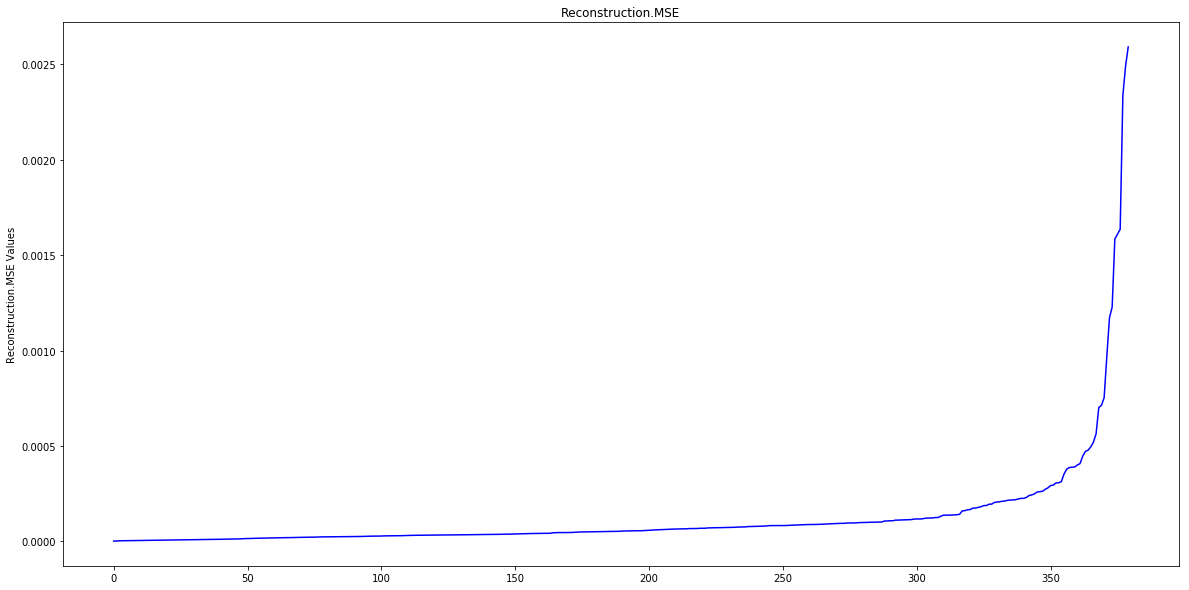

In [90]:
%matplotlib inline  
plt.figure(figsize=(20,10))
x = np.array(amamoly_dataset["Reconstruction.MSE"])
plt.plot(x , color ="blue")
plt.title("Reconstruction.MSE")
plt.ylabel("Reconstruction.MSE Values")
plt.show()


In [61]:
#The autoencoder struggles from index ~340 onwards as the error count accelerates upwards. We can 
#take ~0.0006 as cutoff point to view the anamolies 
amamoly_points = amamoly_dataset[amamoly_dataset["Reconstruction.MSE"] > 0.0006]
amamoly_points.head()

,Reconstruction.MSE
251,0.000622
155,0.001238
103,0.001310
356,0.001425
281,0.001440


# Data Visualization Anamoly Detection

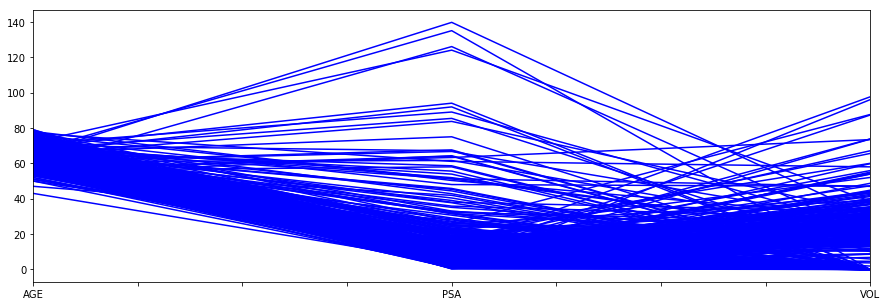

In [91]:
#now lets plot the dataset values and outlier values and try to makes intutive sense on selected outlier values
#for simplicity I am selecting only three columns : AGE ,PSA ,VOL

#plotting the original values
col = ["AGE" ,"PSA" ,"VOL"]
df = dataset.as_data_frame()
df[col].T.plot(color = "blue", figsize = (15,5), legend = False).plot()
plt.show()

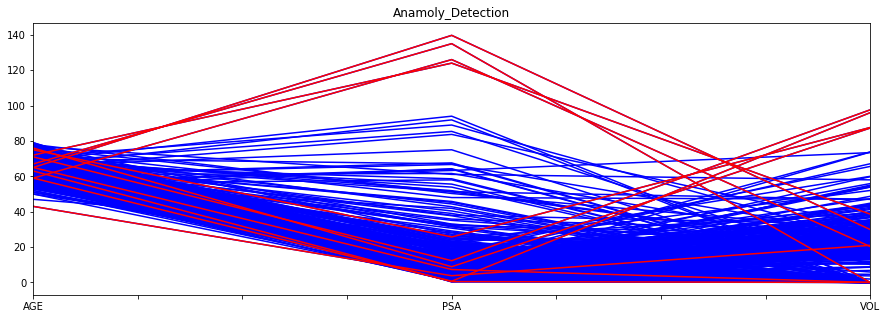

In [92]:
#plotting the outliers and original values together . Red line denotes anomalies & blue line denotes actual dataset
ax = df[col].T.plot(color = "blue", legend = False)
df[col].T[amamoly_points.index].plot(color = "red", legend = False, ax = ax,figsize = (15,5), title = "Anamoly_Detection")
plt.show()

In [93]:
#printing the analmoy dataset
df.T[amamoly_points.index].T

,CAPSULE,AGE,RACE,DPROS,DCAPS,PSA,VOL,GLEASON
251,0.0,43.0,0.0,2.0,1.0,3.8,21.0,6.0
155,0.0,76.0,1.0,2.0,1.0,8.9,87.3,5.0
103,0.0,75.0,1.0,3.0,1.0,25.7,87.6,5.0
356,0.0,63.0,1.0,1.0,1.0,0.5,0.0,0.0
281,0.0,65.0,1.0,1.0,1.0,7.3,0.0,0.0
51,1.0,72.0,1.0,4.0,2.0,124.0,38.6,8.0
233,1.0,59.0,2.0,4.0,1.0,126.0,20.3,8.0
60,0.0,59.0,1.0,2.0,1.0,0.7,96.0,5.0
302,1.0,67.0,1.0,4.0,2.0,135.0,0.0,7.0
354,0.0,71.0,2.0,2.0,1.0,12.3,97.6,5.0
